<a href="https://colab.research.google.com/github/jfcouchot/M1-ISL-IR-/blob/main/StratificationRandomState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pour importer des données depuis Google Drive** 

On monte le dossier drive, puis on lit les fichiers csv 

In [2]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colabs/M2ISL_IR_tp2/"
train_all = pd.read_csv(path+'train.csv')
test_all = pd.read_csv(path+'test.csv')


Mounted at /content/drive


**Splitting Data**

Distributions potentiellement différentes entre le training et le testing

In [ ]:
train_all.Survived.value_counts()/train_all.shape[0]

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split

X = train_all.drop('Survived', axis = 1) 
y = train_all.Survived  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 163035)

In [ ]:
y_train.value_counts() / y_train.shape[0] 

0    0.577247
1    0.422753
Name: Survived, dtype: float64

In [ ]:
y_test.value_counts() / y_test.shape[0]

0    0.77095
1    0.22905
Name: Survived, dtype: float64

**Evaluation des différences entre distributions**

In [ ]:
mn, idx, l= 0,-1,[]
for rs in range(int(3E5)):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = rs)
  dif = abs((y_train.value_counts() / y_train.shape[0])[0] - (y_test.value_counts() / y_test.shape[0])[0])
  l.append(dif)
  if mn < dif :
    idx,mn = rs,dif
print(idx,mn)

135153 0.1977983177452765


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np 

plt.hist(l, bins=20,weights=np.ones(len(l)) / len(l))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [5]:
# Split avec distribution équilibrées 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 20220115,stratify = y)


In [ ]:
y_train.value_counts() / y_train.shape[0] 

In [ ]:
y_test.value_counts() / y_test.shape[0]

**Mise en place apprentissage** 

Restriction aux attributs numériques et complets

In [6]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score  
X = X[['Pclass', 'Sex', 'SibSp', 'Fare']]  

Transforamtion female->1, male->0 

In [8]:
# The “Sex” variable is a string and needs to be one-hot encoded 
X['gender_dummy'] = pd.get_dummies(X.Sex)['female'] 
X = X.drop(['Sex'], axis = 1) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20220115, stratify = y)

**Première évaluation de l'apprentissage**

avec random_state fixé

In [19]:
clf = RandomForestClassifier(n_estimators = 50, random_state = 0) 
clf = clf.fit(X_train, y_train)  
preds = clf.predict(X_test)  
round(accuracy_score(y_true = y_test, y_pred = preds), 3) 

0.793

In [16]:
mne = 0
idxe=-1
leclf=[]
for rs in range(int(1E4)):
  clf = RandomForestClassifier(n_estimators = 50, random_state = rs) 
  clf = clf.fit(X_train, y_train)  
  preds = clf.predict(X_test)  
  sc = accuracy_score(y_true = y_test, y_pred = preds)
  leclf.append(sc)
  if sc > mne :
    idx = rs
    mne = sc

print(idx,mne)

9463 0.8100558659217877


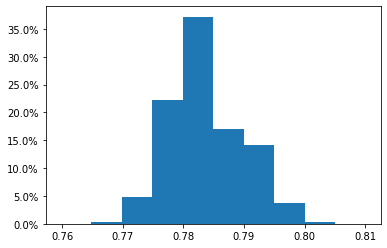

In [17]:
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np 

plt.hist(leclf,weights=np.ones(len(leclf)) / len(leclf))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [18]:
# moyenne et ecart type
res_series = pd.Series(leclf)
res_series.describe()

count    10000.000000
mean         0.783520
std          0.006885
min          0.759777
25%          0.776536
50%          0.782123
75%          0.787709
max          0.810056
dtype: float64

**Mise en place d'une démarche de PVP**

Utilisation de la version PVP de random forest de difprivlib avec import de bibliothèque

In [1]:
!pip install diffprivlib

In [2]:
import diffprivlib as dp

dpclf = dp.models.RandomForestClassifier(n_estimators = 50, random_state = 0,epsilon=0.1)
dpclf = dpclf.fit(X_train, y_train)  
preds = dpclf.predict(X_test)  
round(accuracy_score(y_true = y_test, y_pred = preds), 3)

NameError: ignored